[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BonnenLab/tracking-psychopy-bonnen-2015/blob/main/Tutorial.ipynb)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import scipy
import numpy as np
import pandas as pd
import statsmodels.api as sm
!pip install pykalman
from pykalman import KalmanFilter
import torch
from torch import nn

# IN GOOGLE COLAB uncomment the code below 
# import os
# user = "bonnenlab"
# repo = "tracking-psychopy-bonnen-2015"
# # remove local directory if it already exists
# if os.path.isdir(repo):
#     !rm -rf {repo}
# !git clone https://github.com/{user}/{repo}.git
# !mv tracking-psychopy-bonnen-2015/load.py .
# !cp -r tracking-psychopy-bonnen-2015/image-assets .
# !cp -r tracking-psychopy-bonnen-2015/experiments .
# !rm -r tracking-psychopy-bonnen-2015/
# !ls 

import load


## A. Tracking

#### A.1 Data Collection:
Let's collect a little bit of tracking data!  You have a couple of options:
1. (UNTESTED) If you're running on a local jupyter notebook then you have the option of running directly from the notebook. (You can use the next code cell to run the experiment)

In [4]:
# from experiments.tracking.Bonnen2015_tracking_lastrun import *

2. Run from an installation of psychopy: [https://www.psychopy.org/download.html](https://www.psychopy.org/download.html)

   You'll need to load the experiment in the `PsychopyRunner` window by selecting the blue `+` and navigating to the experiments/tracking file and loading the Bonnen2015_tracking.psyexp.
  

Give yourself a participant ID (e.g., your initials).  Collect a couple of blocks of data.  This will be saved in `./experiment/tracking/data`.

#### A.2 Data Visualization:
Let's visualize this data. 

In [5]:
# load the data
data_file_tracking = 'experiments/tracking/data/'
pid = 'klb'
data_tracking = load.tracking_data(data_file_tracking,pid)
print(f'\nThere are {data_tracking.shape[0]} total trials.')


loading data files...
./experiments/tracking/data/klb_helloworld_2022-07-09_15h15.30.409.csv
./experiments/tracking/data/klb_helloworld_2022-07-09_09h59.46.949.csv

There are 8 total trials.


##### Visualize individual trials - Like Figure 2 of Bonnen et al. 2015
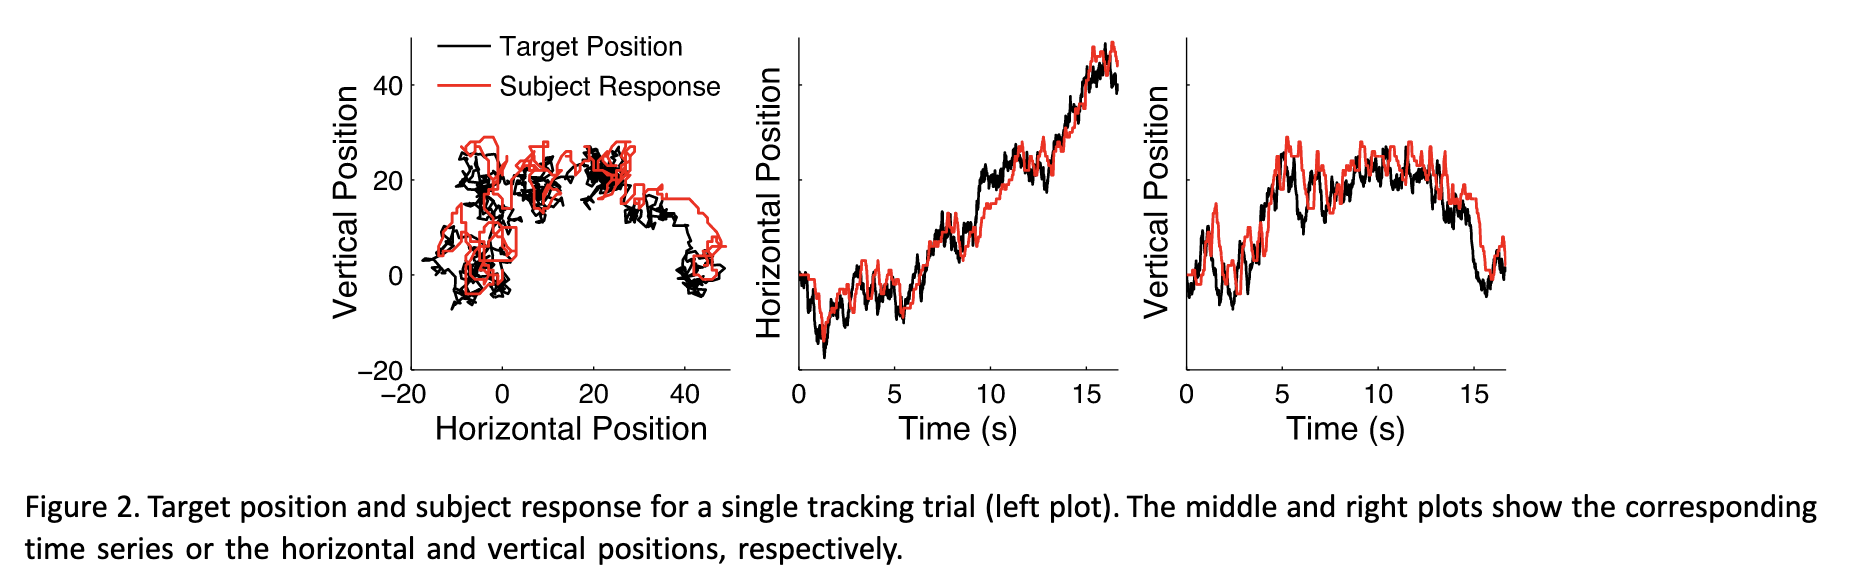

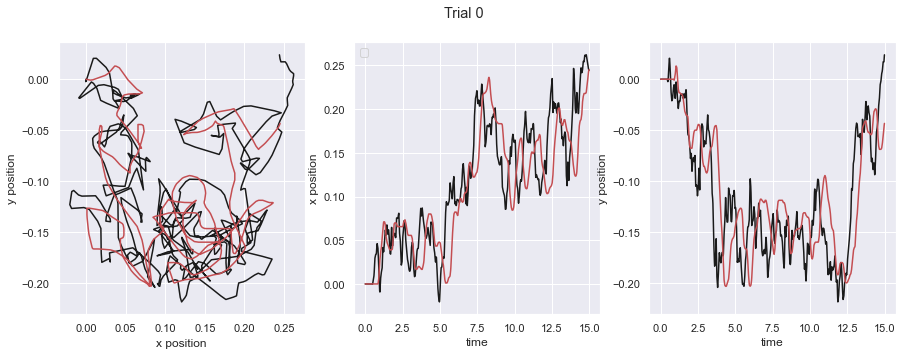

In [6]:
# Visualize a trial of your choice
trialNo = 0;

fig, axs = plt.subplots(1,3,figsize=(15,5))
fig.suptitle(f'Trial {trialNo}')
data_tracking

axs[0].plot(data_tracking.stimulus_x[trialNo],data_tracking.stimulus_y[trialNo],'k')
axs[0].plot(data_tracking.response_x[trialNo],data_tracking.response_y[trialNo],'r')
axs[0].set_xlabel('x position')
axs[0].set_ylabel('y position');
axs[1].legend(['stimulus','response'], ncol=2, loc='upper left');

axs[1].plot(data_tracking.response_time[trialNo],data_tracking.stimulus_x[trialNo],'k')
axs[1].plot(data_tracking.response_time[trialNo],data_tracking.response_x[trialNo],'r')
axs[1].set_xlabel('time')
axs[1].set_ylabel('x position')

axs[2].plot(data_tracking.response_time[trialNo],data_tracking.stimulus_y[trialNo],'k')
axs[2].plot(data_tracking.response_time[trialNo],data_tracking.response_y[trialNo],'r')
axs[2].set_xlabel('time')
axs[2].set_ylabel('y position');

# Q: Can you add an offset to the data_tracking.response_time[trialNo] to figure out the time delay in the response?

#### A.3 Analyze your data!  --  Cross-correlograms

In [7]:
def cross_correlation(sig1,sig2):
    corr = sm.tsa.stattools.ccf(sig2, sig1)
    # Remove padding and reverse the order
    corr[0:(len(sig2)+1)][::-1] 
    return corr

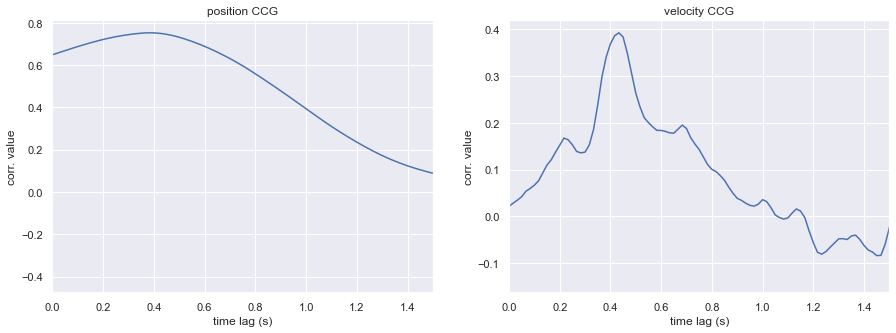

In [8]:
# Visualize a single CCG in position and/or velcity
trialNo = 1;

stim = data_tracking.stimulus_x[trialNo]
response = data_tracking.response_x[trialNo]
ccg = cross_correlation(stim,response)
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(np.arange(0,ccg.shape[0])/data_tracking.frameRate[trialNo],ccg)
axs[0].set_xlabel('time lag (s)')
axs[0].set_ylabel('corr. value')
axs[0].set_title('position CCG')
axs[0].set_xlim(0,1.5)


# Visualize a single CCG in position
stim = data_tracking.stimulus_x[trialNo]
response = data_tracking.response_x[trialNo]
ccg = cross_correlation(np.diff(stim),np.diff(response))

plt.plot(np.arange(0,ccg.shape[0])/data_tracking.frameRate[trialNo],ccg)
plt.xlabel('time lag (s)')
plt.ylabel('corr. value')
plt.title('velocity CCG')
plt.xlim(0,1.5);


# Q1: How would you leverage one or both of these CCGs to calculate the response delay?
#     If you're feeling adventurous, try writing some code to extract that value from one or both ccgs
#     hint: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html

# Q2: What's the relationship between this example of continuous psychophysics and reverse correlation?

In [9]:
# Calculate velocity CCGs for every trial
nTrials = data_tracking.shape[0]

# Perform a cross correlation for each trial
ccg_x = [cross_correlation(np.diff(data_tracking.stimulus_x[tt]),np.diff(data_tracking.response_x[tt])) for tt in range(0,nTrials)]
ccg_y = [cross_correlation(np.diff(data_tracking.stimulus_y[tt]),np.diff(data_tracking.response_y[tt])) for tt in range(0,nTrials)]

# Save the CCGs
data_tracking['CCG_x'] = ccg_x
data_tracking['CCG_y'] = ccg_y

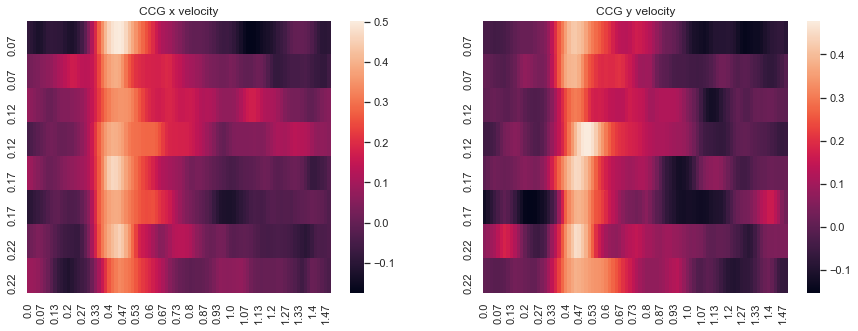

In [10]:
# Visualize the velocity CCGs for X and Y sorted by blobWidth
data_tracking=data_tracking.sort_values('blobWidth')

# Put the data in a format that the heat maps are comfortable with
CCG_x = pd.DataFrame(np.stack(ccg_x)[:,:90],columns = data_tracking.response_time[0][:90].round(2), index=data_tracking.blobWidth.to_numpy())
CCG_y = pd.DataFrame(np.stack(ccg_y)[:,:90],columns = data_tracking.response_time[0][:90].round(2), index=data_tracking.blobWidth.to_numpy())

# Plot the data
fig, axs = plt.subplots(1,2,figsize=(15,5))
sns.heatmap(CCG_x,ax=axs[0])
axs[0].set_title('CCG x velocity')
sns.heatmap(CCG_y,ax=axs[1])
axs[1].set_title('CCG y velocity');

#### A.3 Analyze your data!  -- Kalman Filter

Ok but first let's play a little with the Kalman filter... to figure out what's going on.

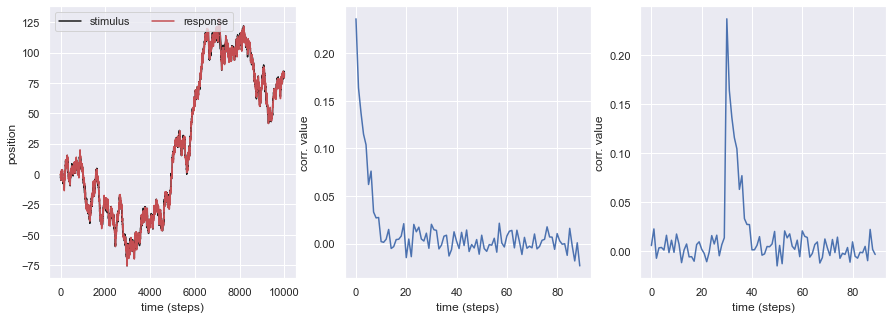

In [11]:
# simulate from a simple kalman filter
Q = 1
R = 15
N = 10000
ww = np.random.normal(0, np.sqrt(Q), (1,N))
x = ww.cumsum()
vv = np.random.normal(0,np.sqrt(R),(1,N))
measurements = x + vv

kf = KalmanFilter(
    transition_matrices = [1], 
    observation_matrices = [1], 
    transition_covariance = Q,
    observation_covariance = R)

xhat, _ = kf.filter(measurements)

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].plot(x,'k')
axs[0].plot(xhat,'r')
axs[0].set_xlabel('time (steps)')
axs[0].set_ylabel('position');
axs[0].legend(['stimulus','response'], ncol=2, loc='upper left');


# You'll notice that this doesn't really match human CCGs...
ccg = cross_correlation(np.diff(x),np.diff(xhat.squeeze()))
axs[1].plot(ccg[:90])
axs[1].set_xlabel('time (steps)')
axs[1].set_ylabel('corr. value');

# Try calculating a ccg with a relative delay to the response
n=30
ccg2 = cross_correlation(np.diff(x[n:]),np.diff(xhat[:-n].squeeze()))
axs[2].plot(ccg2[:90])
axs[2].set_xlabel('time (steps)')
axs[2].set_ylabel('corr. value');

# Q1: What happens as you increase the number of time steps in the data (N)?

# Q2: What happens as you increase/decrease observation variance (R)?

###  CONSTRUCTION ZONE

I was going to show how to use the Kalman filter framework to fit the data... but turns out torch has no implementation of sparse diagonal matrices :(  

If you're curious to about the details of the math and want to see an implementation, I recommend having a look at the [appendix](https://pillowlab.princeton.edu/pubs/Bonnen15_JOV_kalmantracking.pdf) and exploring the [matlab implementation](https://github.com/kbonnen/BonnenEtAl2015_KalmanFilterCode) of Kalman filter fitting on github.

The code has comments showing you where it matches up with the appendix.

## B. Comparable measurement of visual sensitivity using 2AFC

Run from an installation of psychopy: [https://www.psychopy.org/download.html](https://www.psychopy.org/download.html)

You'll need to load the experiment in the `PsychopyRunner` window by selecting the blue `+` and navigating to the experiments/tracking file and loading the Bonnen2015_2afc.psyexp.

Give yourself a participant ID (e.g., your initials).  Collect a couple of blocks of data.  This will be saved in `./experiment/2afc/data`.

In [14]:
# load 2afc data
data_file_2afc = 'experiments/2afc/data/' 
pid = '067016'
data_2afc = load.twoAFC_data(data_file_2afc,pid)
print(f'\nThere are {data_2afc.shape[0]} total trials.')

loading data files...
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_01h57.26.528.csv
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_11h24.16.192.csv
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_11h23.17.519.csv
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_11h13.37.777.csv
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_11h18.37.343.csv
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_11h14.45.111.csv
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_11h17.38.154.csv
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_11h22.17.093.csv
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_11h16.40.299.csv
experiments/2afc/data/067016_Bonnen2015_2afc_2022-07-05_11h15.42.746.csv

There are 440 total trials.


In [21]:
# Visualize the psychometric functions
data_2afc['chose_right'] = data_2afc.response == 'right'
data_2afc# 

,blobHeight,blobWidth,offset,response,chose_right
1,0.4118,0.17,-0.08,left,False
2,0.4118,0.17,0.04,right,True
3,0.5833,0.12,-0.01,left,False
4,1.0000,0.07,-0.04,left,False
5,1.0000,0.07,0.16,right,True
...,...,...,...,...,...
40,1.0000,0.07,0.16,right,True
41,1.0000,0.07,0.02,right,True
42,0.5833,0.12,0.01,right,True
43,0.5833,0.12,0.08,right,True


In [ ]:
# Fit the psychometric functions


# Q: 

In [ ]:
# CONSTRUCTION ZONE PROGRESS
# You can probably ignore everything after here if you're not Kate
# 
# # Functions for fitting

# def simulate(Q,R,nSamples,nTrials):
#     kf = KalmanFilter(
#         transition_matrices = [1], 
#         observation_matrices = [1], 
#         transition_covariance = Q,
#         observation_covariance = R)
    
#     responses=[]
#     stimuli = []
#     for i in range(nTrials):
#         ww = np.random.normal(0, np.sqrt(Q),N)
#         x = ww.cumsum()
#         vv = np.random.normal(0,np.sqrt(R),N)
#         measurements = x + vv
#         xhat, _ = kf.filter(measurements)
#         responses.append(xhat.squeeze())
#         stimuli.append(x)
    
    
#     Xhat = np.stack(responses,axis=1)
#     X = np.stack(stimuli,axis=1)
    
#     return X,Xhat

# class FittingModel(nn.Module):
#     """Custom Pytorch model for gradient optimization.
#     """
#     def __init__(self,Q):
        
#         super().__init__()
#         # initialize weights with random numbers
#         weights = torch.distributions.Uniform(10, 100).sample((1,))
#         # make weights torch parameters
#         self.weights = nn.Parameter(weights)
#         self.Q = Q
        
#     def forward(self,X,Xhat):
#         """Implement function to be optimised. In this case, an exponential decay
#         function (a + exp(-k * X) + b),
#         """
#         r = self.weights
#         return negLogLikelihoodr(r,self.Q,X,Xhat)
    
# def training_loop(model,optimizer,X,Xhat, n=1000):
#     "Training loop for torch model."
#     losses = []
#     for i in range(n):
#         loss = model(X,Xhat)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         losses.append(loss)  
#     return losses

# def negLogLikelihoodr(rr,Q,X,Xhat):
    
#     numTrials = X.shape[1]          # number of trials
#     N = X.shape[0]                  # number of samples
#     nLL = 0            
# #     rr = np.exp(rr)                 # exponentiate observation noise variance                  
    
#     pp = Q/2 * (torch.sqrt(1+4*rr/Q)-1)   # posterior variance - Eq B8
#     k = (pp+Q)/(pp+Q+rr)         # Kalman Gain - eq B10
# #     d = torch.diag(torch.ones(N),0)+torch.diag((k-1)*torch.ones(N-1),-1);    # Eq B12
#     # I'm going to have to implement this manually :(
    
#     #  NOTE: The appendix describes maximum likelihood fitting of R using 
#     #  p(xhat|x) (see Equation B14).  It is simpler (and significantly faster
#     #  for the MATLAB implementation) to maximize the likelihood that 
#     #  (D*xhat - K*x) ~ N(0,K^2*R)

#     for i in range(numTrials):
#         x = X[:,i];
#         xhat = Xhat[:,i];
#         temp = torch.matmul(d,xhat) - (k*x); # eq B11
#         nLL -=  (-1/(2*k**2*rr)*torch.matmul(temp.T,temp) - N/2*np.log(rr) - N*np.log(k)); # the negative log likelihood that (D*xhat - K*x) ~ N(0,K^2*R) 

                     
#     return nLL


# # Do a simulation
# Q = torch.tensor(1);
# R = torch.tensor(100);
# nSamples = 100
# nTrials = 10
# X,Xhat = simulate(Q,R,nSamples,nTrials)

# # Fit the simulation
# m = FittingModel(Q)
# opt = torch.optim.Adam(m.parameters(), lr=0.001)
# # training_loop(m,opt,torch.tensor(X),torch.tensor(Xhat),n=10)
# negLogLikelihoodr(torch.tensor(R),torch.tensor(Q),torch.tensor(X),torch.tensor(Xhat))